This notebook was created based on the very last project I did for my MBA degree. I was taking the class "Programming for Business Analytics" and the assignment was essentially to do a project that was relevant to our work and applied what we learned in the class. The final deliverable was an "Amazon 6-pager" and oddly the professor didn't want there to be any code in it. The class taught us basic SQL and Python with some tenuous applications to traditional statistical analytics so naturally I decided to do a machine learning project.

In [46]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

### Anomaly Detection
By day I am a security "engineer". By night... I sleep. One of the many responsibilities I have in my day job is to respond to alerts that come in from our managed security service provider (MSSP). My organization has a very small security team and, because of my aforementioned night job, we need someone to keep an eye on things when I'm not awake. So, we send all of our log data to this MSSP and trust (pay) them to filter the signal from the noise. 

One of the security challenges my organization has is: what is the definition of an anomaly? We are an institution of higher education (a college not a dispensary) and as such our users often move about the world logging into things willy nilly from all sorts of devices. This makes it challenging to determine whether a login is truly anomalous and possibly malicious. Decent hackers these days make it even harder by using VPNs or public cloud to mask their true location. So the problem I wanted to gain some insight into was: how does one detect an anomaly, and can I do it "better" than Microsoft?

### The data
The first problem I had was finding data that I knew had anomalies in it. I have access to endless amounts of login data from my organization, but just like when someone asks you out of context what your favorite song is, I just couldn't find anything that worked. 

Ultimately, I doctored a data set since this was more of a proof of concept than a true attempt at developing something for production. I took my own login data and sprinkled in some random logins from other users. 

The next callenge was deciding what variables to focus on. I had 17 categories for each login attempt. 

In [26]:
df = pd.read_csv("/Users/jbackon/Repos/blog/jrbackon.github.io/backon_data.csv")
print(len(df.columns))
df.columns

17


Index(['Date (UTC)', 'User agent', 'Username', 'Application', 'Resource',
       'IP address', 'Location', 'Status', 'Sign-in error code',
       'Failure reason', 'Client app', 'Browser', 'Operating System',
       'Multifactor authentication result', 'IP address (seen by resource)',
       'Conditional Access', 'Managed Identity type'],
      dtype='object')

Usually what I look at when examining logs is: location, device, and whether the login was successsful. Based on this, I decided to use four variables to help detect anomalies:
- Status (whether the login was successful or not)
- User Agent (information sent with the login that has clues to the type of device used to login)
- Browser (more information about the device used to login)
- Location

Now I just needed to figure out how to do the detection.

### Isolation Forests
After doing some research it turns out that there is a very clever algorithm to detect outliers in a given range of numbers. It's called an isolation forest. Here's how it works.

Say I have a set of data (here represented by a list of numbers).

In [27]:
data = [1,6,9,14,20,23,46,1002]

To isolate the outlier what I can do is pick a random number in the range of values in the set. In this case I'll pick 15. I then split the data into two groups. Numbers smaller than 15 and numbers bigger.

In [ ]:
branch1 = [1,6,9,14]
branch2 = [20,23,46,1002]

I then repeat this process until all numbers have been isolated, or I reach a set number of splits. We can see if I pick 7 for the smaller set and 50 for the bigger that I will have already isolated one number. The full set of splits is known as a "tree".

In [ ]:
branch3 = [1,6]
branch4 = [9, 14]
branch5 = [20,23,46]
leaf1 = [1002]

Once a branch only has one value then it becomes a leaf. The values that form leafs the fastest are most likely the outliers. The algorithm repeats this process over and over again using different numbers to do the splitting. This creates a group of "trees" or a "forest" hence the name of the algorithm. 

The machine learning aspect has to do with the relative "distance" to a leaf for each data point across all of the trees. Based on these combined distances the algorithm assigns an "anomaly score" that suggests the probability that the point is an outlier. Then, based on inputs to the algorithm it picks a threshold value for the distribution of anomaly scores and all values smaller than the threshold get classified as anomalies.

It might sound a little complicated, and I don't know a good way of doing visualizations in python (yet), but I have an image later that might help. The nice things about this algorithm though is it is super fast and doesn't take much compute power. This is useful especially if this method is going to be used for real-time detection.

### Preparing the data
So, I had my algorithm, but there was a problem. Most of my data was categorical and not numerical. I needed numerical data to use the isolation forest algorithm. Luckily, Pandas has a neat method for encoding data. This simply assigns a random number to each value in each category.

In [28]:
df['status_encoded'] = df['Status'].astype('category').cat.codes
df['user_agent_encoded'] = df['User agent'].astype('category').cat.codes
df['browser_encoded'] = df['Browser'].astype('category').cat.codes
df['location_encoded'] = df['Location'].astype('category').cat.codes

So now instead of:

In [ ]:
non_encoded = ['Status', 'User agent', 'Browser'] # location removed for privacy
df[non_encoded].head(5)

,Status,User agent,Browser
0,Success,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Edge 131.0.0
1,Interrupted,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Edge 131.0.0
2,Success,Windows-AzureAD-Authentication-Provider/1.0,NaN
3,Success,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,IE 7.0
4,Success,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Edge 131.0.0


My data looks like:

In [30]:
test_columns = ['user_agent_encoded', 'browser_encoded', 'location_encoded', 'status_encoded']
df[test_columns].head(5)

,user_agent_encoded,browser_encoded,location_encoded,status_encoded
0,9,2,0,2
1,9,2,0,1
2,13,-1,0,2
3,1,5,8,2
4,11,2,8,2


I'm almost ready to go. I now need to split the data into test and prediction sets as is standard for any machine learning problem. I chose to use a 60:40 test:prediction split for reasons...

In [34]:
test_data, prediction_data = train_test_split(df, test_size=0.6, random_state=42)


### Training and using the model
I can now train the IsolationForest model provided by sklearn. 
- **n_estimators**: provides the maximum number of branches for each tree.
- **contamination**: is my best guess as to how much of the data is an anomaly. This is used to help the algorithm pick an appropriate anomaly score threshold.

I fit the model with the test data only using the four encoded variables I mentioned earlier.

In [35]:
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model.fit(test_data[test_columns])

IsolationForest(contamination=0.01, random_state=42)

Now, that the model is trained I apply it to the prediction set to see how it performs. In the code below, I'm adding the anomaly score and determination of whether the data point is an anomaly to the prediction data set just so I can review the results based on the original data.

In [37]:
prediction_data['anomaly_score'] = model.decision_function(prediction_data[test_columns])
prediction_data['is_anomalous'] = model.predict(prediction_data[test_columns])  # -1: anomaly, 1: normal

Here is an example of some encoded data and the associated anomaly score. 

In [47]:
prediction_data[test_columns + ['anomaly_score', 'is_anomalous']].head(5)

,user_agent_encoded,browser_encoded,location_encoded,status_encoded,anomaly_score,is_anomalous
428,13,-1,8,2,0.227029,1
440,7,1,0,2,0.292787,1
9,5,6,5,0,-0.014148,-1
468,8,1,8,2,0.312700,1
39,9,2,8,2,0.261850,1


To better understand when a given anomaly score is classified as an anomaly it helps to look at the distribution of anomaly scores shown below.

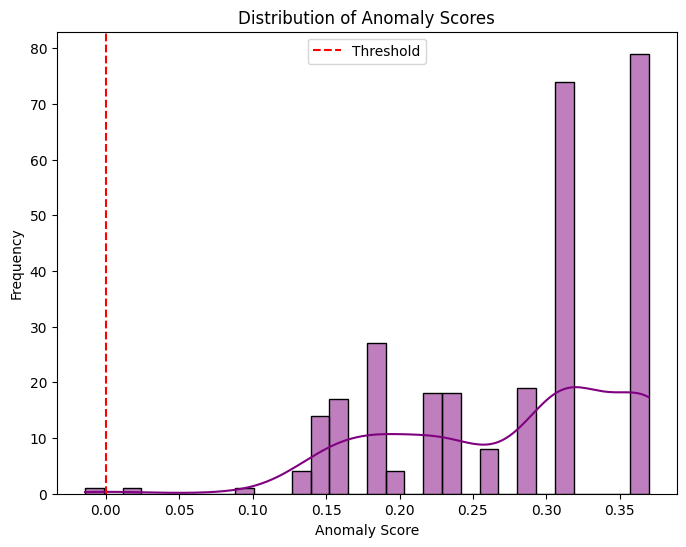

In [45]:
# Histogram of anomaly scores
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.histplot(prediction_data['anomaly_score'], kde=True, bins=30, color='purple')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()


The histogram shows that anything with an anomaly score less than 0 was classified an an anomaly. The interesting thing to note is that, if I changed the **contamination** value when I was training the model, then the threshold would be different. In fact, the first time I built this model I used a value of 0.1 instead of 0.01. This told the model to expect 10% of the data to be anomalous. Given I only had about 50 data points in my set this value generated quite a few false positives. 

### Conclusions
So my initial conclusion is that I definitely can't do this better than Microsoft. Building a model is one thing. Building a production ready web application that can ingest data for thousands of users and provide near real-time anomaly detections is quite another. I like that I now better understand how the underlying technologies work and feel that I have a good foundation for more advanced study in this area. Specifically, it might be worth digging into the algorithm itself and seeing how it works under the hood. If I do this, I'll be sure to write about it.